# Estimating the SCC using CIL damage functions and the FAIR SCM

This notebook builds on the [FAIR example notebook](./Example-Usage.ipynb) and adds an SCC simulation using damage functions from the Climate Impact Lab's mortality work.

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2020
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

All of this work and the source data can be found in the Climate Impact Lab's [FAIR-SCM repo](https://gitlab.com/ClimateImpactLab/Climate/FAIR-SCM) on gitlab.

Version 0.2 update 6/22/18:
Version 0.2 updates the damages calculation to take the linear extrapolation of the quadratic damage function for post-2100 periods as one alternative, or to hold the damage function constant at 2100 values for another alternative, and output both results. In addition, it is formatted to accept multiple scenarios within a given damage function .csv file, and select one of them for analysis and output.
10/4/18: Updated the FAIR temperature anomaly from 0.8C to 0.6C, per instructions from Bob.

Version 0.3 update 12/6/18:
Version 0.3 recenters GMST on the 2001 - 2010 period instead of the 1986 - 2005 period. This is more consistent with the way the GCP projections are "rebased" to the 2001 - 2010 period. Also note for reference that this is the version in which the Murphy Topel VSL was first incorporated as one of the valuation options in the damage function (though that is not specific to this code base).

Version 0.4 update 03/16/19: Integrates median FAIR parameters into calls to the FAIR module.

Version 0.5 update 10/15/19:
Version 0.5 updates the base year for the calculation of net present damages (from 2015 to 2020), and removes the inflation adjustment. From mortality version 0.4 on, the notebook expects that damage functions are estimated in the relevant dollar year, which at this time is 2019$.

Update 5/11/20:
- Merges together the point estimate and damage function uncertainty SCC notebook (see `Code toggles` cell).
- Incorporates new uncertainty approach, which uses 19 quantile damage functions and fits distribution to the SCCs associated with each.
- Imposes fair package version requirement: v1.3.2

## Set up workspace

In [4]:
%matplotlib inline

In [5]:
! pip install fair==1.3.2 

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)
import os
import glob

from datetime import datetime

import sys
sys.path.append('..')
import load_fair

from scipy.stats import lognorm, norm

In [68]:
# mortality specific parameratization for code below
version = 'v0.5' # code version
specification = 'mortality_quadratic_IGIA' # sector specific tag
ssp = 'SSP3'
MAGNITUDE_OF_DAMAGES = 1#e9  # magnitude of damage function values

# DB = '/mnt/Global_ACP/MORTALITY/release_2020/data'
# INPUT_path = '{}/4_damage_function/wo_costs'.format(DB)
# OUTPUT_path = '{}/5_scc/global_scc/quadratic/wo_costs'.format(DB)

DB = '/shares/gcp/estimation/mortality/release_2020/data'
INPUT_path = '{}/2_projection/3_impacts/main_specification/raw/hybrid_damages/integration_data/SSP3_replication'.format(DB)
OUTPUT_path = '{}/5_scc/global_scc/quadratic/hybrid_scc'.format(DB)

In [69]:
# Code toggles

# point estimate (`point-est`) or df uncertainty (`df-uncertainty`) (note: df uncertainty will not generate some plots)
scc_output = 'point-est'

# generate plots or not
generate_plots = False

# Run option: whether or not to hold the post-2100 damage function constant.
hold_2100_damages_fixed = False

In [70]:
if scc_output == 'point-est':
    #index_cols = ['year', 'age_adjustment', 'vsl_value', 'heterogeneity']
    index_cols = ['year', 'discount_type', 'model']
    file_infix = ''
elif scc_output == 'df-uncertainty':
    index_cols = ['year', 'age_adjustment', 'vsl_value', 'heterogeneity', 'pctile']
    file_infix = 'quantilereg_'
    specification = '{}_{}'.format(specification, scc_output)
else:
    raise NotImplementedError

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions of methane and nitrous oxide are switched on.

# SCC

We can compute the SCC by adding an additional pulse in CO2 emissions to the RCP trajectory.

### Scenario design

This study uses a 100 Gt C emissions pulse. You can change the pulse amount by modifying the `PULSE_AMT` variable below, and adapting the `CONVERSION` value to match. 


In [71]:
PULSE_YEAR = 2020  # year in which pulse will be emitted. Update the PULSE_DEFLATOR accordingly
PULSE_AMT = 1.0  # in Gt C = 1e9 ton C

# CONVERSION is in units of [pulse/tCO2] = [1 pulse/PULSE_AMT GtC * 1 GtC/1e9 tC * 12tC/44tCO2]
# This is used to convert costs ($Bn_2019 / pulse) to SCC ($_2019/ton CO2).
# Therefore, it should be the inverse of any changes to PULSE_AMT
CONVERSION = 1.0 / PULSE_AMT / 1e9 * 12.011 / 44.0098

In [72]:
fair_temperatures_anomaly = load_fair.temperatures_anomaly(PULSE_YEAR = PULSE_YEAR, 
                                                           PULSE_AMT = PULSE_AMT,
                                                           make_plots = False, 
                                                           output = OUTPUT_path )

Finished loading FAIR


In [73]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
import fair.RCPs
rcp85.__name__
pulse, pulse_co2_fossil = {}, {}
t = 'teststring'
t + t[::-1]

'teststringgnirtstset'

## Incorporate a single damage function

This is the damage function from Tamma, with a set of coefficients for each year.

Version 0.3 update: The damage function can now be held constant or allowed to vary post-2100. 
Note: damages are estimated in Billion 2005 \$PPP, so use the U.S. GDP deflator for 2005 from the World Bank. Take the ratio with the `PULSE_YEAR` deflator (U.S. GDP deflator for the pulse_year from the World Bank) to convert the dollars from 2005 \$PPP to `PULSE_YEAR` \$PPP.

Note: the damage functions passed have columns for `anomalymin` and `anomalymax` which are not used, so they are dropped after reading in the .csv files below. In dropping them, I assume the parameters fit to the damage function are given by `coeff_names` as defined here.

Version 0.5 update: this dollar year conversion described above is no longer needed, since damage functions will now be estimated in current dollar years, e.g. 2019$

In [21]:
# Time the SCC calculation
startTime = datetime.now()

# damage function coeffs filepath 
#fp = os.path.join('{}/mortality_wo_costs_coefficients_quadratic_IGIA_MC_global_poly4_uclip_sharecombo_{}{}.csv'
#                    .format(INPUT_path, file_infix, ssp))
fp = '/shares/gcp/estimation/mortality/release_2020/data/2_projection/3_impacts/main_specification/raw/hybrid_damages/integration_data/SSP3_replication/adding_up_constant_model_collapsed_damage_function_coefficients.csv'

def read_damage_func(fp, index):
    df = pd.read_csv(fp, index_col=index)
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ds = read_damage_func(fp, list(range(len(index_cols)))).to_dataset(name='SSP3')

# Drop 'anomalymin' and 'anomalymax' from the coeff list. Only keep the constants and the betas.
ds = ds.sel(coeff=[c for c in ds.coeff.values if 'anomaly' not in c])

In [74]:
fp = '/shares/gcp/estimation/mortality/release_2020/data/2_projection/3_impacts/main_specification/raw/hybrid_damages/integration_data/adding_up_constant_model_collapsed_damage_function_coefficients.csv'
df = pd.read_csv(fp, index_col=[4, 1, 2])
df = df.drop(columns=['Unnamed: 0', 'ssp'])
df.columns.names = ['coeff']
ds = df.stack('coeff').to_xarray().to_dataset(name='SSP0')
ds = ds.sel(coeff=[c for c in ds.coeff.values if 'anomaly' not in c])

In [75]:
ds

<xarray.Dataset>
Dimensions:        (coeff: 3, discount_type: 1, model: 1, year: 281)
Coordinates:
  * year           (year) int64 2020 2021 2022 2023 2024 ... 2297 2298 2299 2300
  * discount_type  (discount_type) object 'constant_model_collapsed'
  * model          (model) object "['IIASA GDP', 'OECD Env-Growth']"
  * coeff          (coeff) object 'cons' 'beta1' 'beta2'
Data variables:
    SSP0           (year, discount_type, model, coeff) float64 9.895e+10 ... ...

In [63]:
# old ds, do not run cell

<xarray.Dataset>
Dimensions:         (age_adjustment: 3, coeff: 3, heterogeneity: 2, vsl_value: 1, year: 286)
Coordinates:
  * age_adjustment  (age_adjustment) object 'mt' 'vly' 'vsl'
  * vsl_value       (vsl_value) object 'epa'
  * heterogeneity   (heterogeneity) object 'popavg' 'scaled'
  * year            (year) int64 2015 2016 2017 2018 ... 2297 2298 2299 2300
  * coeff           (coeff) object 'cons' 'beta1' 'beta2'
Data variables:
    SSP3            (age_adjustment, vsl_value, heterogeneity, year, coeff) float64 ...

In [76]:
coeffs_all_years = (
    ds.to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)

# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)
    

In [55]:
if generate_plots and scc_output == 'point-est':
    fig, axes = plt.subplots(1, len(ds.coeff.values), figsize=(15, 4))

    for i, coeff in enumerate(ds.coeff.values):
        lines = coeffs_all_years.sel(variable=ssp,age_adjustment='vsl', vsl_value='epa', heterogeneity='scaled')[coeff].plot.line(
            x='year', ax=axes[i], add_legend=False)
        
        axes[i].set_title(coeff)

    sns.despine()

In [68]:
print('{}/figures/damage_functions_IGIA_{}_{}_{}_2100-fixed-{}.pdf'.format(OUTPUT_path, specification, ssp, version, hold_2100_damages_fixed))

/mnt/Global_ACP/MORTALITY/release_2020/data/5_scc/global_scc/quadratic/wo_costs/figures/damage_functions_IGIA_mortality_quadratic_IGIA_SSP3_v0.5_2100-fixed-False.pdf


In [77]:
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots and scc_output == 'point-est':
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.age_adjustment)*len(coeffs_all_years.vsl_value)*len(coeffs_all_years.heterogeneity)
    fig, axes = plt.subplots(min(2, numvars), (numvars+1)//2, figsize=(15, 7))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    if 1 == 1:
        current_row = 0
        for hi, h in enumerate(coeffs_all_years.heterogeneity.values):
            current_col = -1
            if hi == 1:
                current_row = 1
            for ai, a in enumerate(coeffs_all_years.age_adjustment.values):
                for vi, v in enumerate(coeffs_all_years.vsl_value.values):
                    current_col += 1
                    lines = []
                    for y in reversed(coeffs_all_years.year.values[:86:5]):
                        #print(current_row, current_col)
                        lines.append(
                            axes[current_row, current_col].plot(
                                temps.values,
                                spaghetti.sel(vsl_value=v, age_adjustment=a, heterogeneity=h, year=y, variable=ssp).values,
                                color=matplotlib.cm.Blues_r((y-2015.0)/(2100-2000)),
                                label=int(y)))

                    axes[current_row, current_col].set_facecolor('white')
                    axes[current_row, current_col].set_title('{}, {}, {}, {}'.format(v, a, h, ssp))
                    axes[current_row, current_col].set_xbound(lower=0, upper=10)
                    axes[current_row, current_col].set_ybound(lower=-300000, upper=900000)

        plt.subplots_adjust(right=0.85)
        axes[0, -1].legend(
            list(reversed(lines))[::5],
            labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
            loc='center left',
            bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
        fig.set_facecolor('white')

        sns.despine()
        fig.savefig('{}/figures/damage_functions_IGIA_{}_{}_{}_2100-fixed-{}.pdf'
                    .format(OUTPUT_path, specification, ssp, version, hold_2100_damages_fixed))



<ipython-input-70-657bda31e0e4>:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  axes[0, -1].legend(


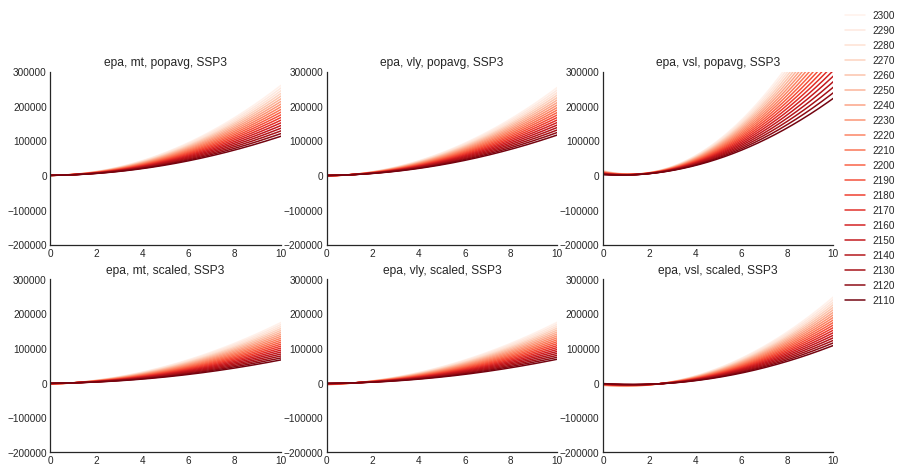

In [70]:
if generate_plots and scc_output == 'point-est':
    temps = np.linspace(-5, 15, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.age_adjustment)*len(coeffs_all_years.vsl_value)*len(coeffs_all_years.heterogeneity)
    fig, axes = plt.subplots(min(2, numvars), (numvars+1)//2, figsize=(15, 7))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    if 1 == 1:
        current_row = 0
        for hi, h in enumerate(coeffs_all_years.heterogeneity.values):
            current_col = -1
            if hi == 1:
                current_row = 1
            for ai, a in enumerate(coeffs_all_years.age_adjustment.values):
                for vi, v in enumerate(coeffs_all_years.vsl_value.values):
                    current_col += 1
                    lines = []
                    for y in reversed(coeffs_all_years.year.values[85::10]):
                        #print(current_row, current_col)
                        lines.append(
                            axes[current_row, current_col].plot(
                                temps.values,
                                spaghetti.sel(vsl_value=v, age_adjustment=a, heterogeneity=h, year=y, variable=ssp).values,
                                color=matplotlib.cm.Reds_r((y-2100.0)/(2300-2100)),
                                label=int(y)))

                    axes[current_row, current_col].set_facecolor('white')
                    axes[current_row, current_col].set_title('{}, {}, {}, {}'.format(v, a, h, ssp))
                    axes[current_row, current_col].set_xbound(lower=0, upper=10)
                    axes[current_row, current_col].set_ybound(lower=-200000, upper=300000)

        plt.subplots_adjust(right=0.85)
        axes[0, -1].legend(
            list(reversed(lines))[::5],
            labels=list(reversed(coeffs_all_years.year.values[85:]))[::10],
            loc='center left',
            bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
        fig.set_facecolor('white')

        sns.despine()
        fig.savefig('{}/figures/damage_functions_IGIA_{}_{}_{}_post-2100-fixed-{}.pdf'
                    .format(OUTPUT_path, specification, ssp, version, hold_2100_damages_fixed))



### Compute damages

Combine the damage function coefficients with the FAIR temperatures:

$$d_y = c_2*T_y^2+C_1*T_y+C_0 \hspace{1in}\forall \hspace{0.1in} y \in [2020, 2300]$$

In [79]:
damages = (
    (coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)).sum(dim='coeff'))

# Fix the coordinate re-order bug introduced by holding the damage function constant post-2100.
if scc_output == 'point-est':
    damages = damages.transpose('variable', 'year', 'pulse', 'rcp', 'discount_type', 'model')
elif scc_output == 'df-uncertainty':
    damages = damages.transpose('variable', 'year', 'pulse', 'rcp', 'age_adjustment', 'vsl_value', 'heterogeneity', 'pctile')
else:
    raise NotImplementedError

In [80]:
damages

<xarray.DataArray (variable: 1, year: 281, pulse: 2, rcp: 4, discount_type: 1, model: 1)>
array([[[[[[ 3.64138685e+10]],

          [[ 3.51856221e+10]],

          [[ 4.37832208e+10]],

          [[ 1.20234841e+10]]],


         [[[ 3.61806485e+10]],

          [[ 3.49502109e+10]],

          [[ 4.35591736e+10]],

          [[ 1.17608510e+10]]]],



        [[[[ 4.65391831e+10]],
...
          [[ 9.84411667e+13]]]],



        [[[[-3.06272524e+12]],

          [[ 1.75962233e+12]],

          [[ 1.26090111e+13]],

          [[ 9.88770819e+13]]],


         [[[-3.06403011e+12]],

          [[ 1.76972205e+12]],

          [[ 1.26256787e+13]],

          [[ 9.88992354e+13]]]]]])
Coordinates:
  * year           (year) float64 2.02e+03 2.021e+03 ... 2.299e+03 2.3e+03
  * variable       (variable) object 'SSP0'
  * discount_type  (discount_type) object 'constant_model_collapsed'
  * model          (model) object "['IIASA GDP', 'OECD Env-Growth']"
  * pulse          (pulse) <U5 'rcp' 'pulse'
  * rcp            (rcp) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'

### Plot time series of damages

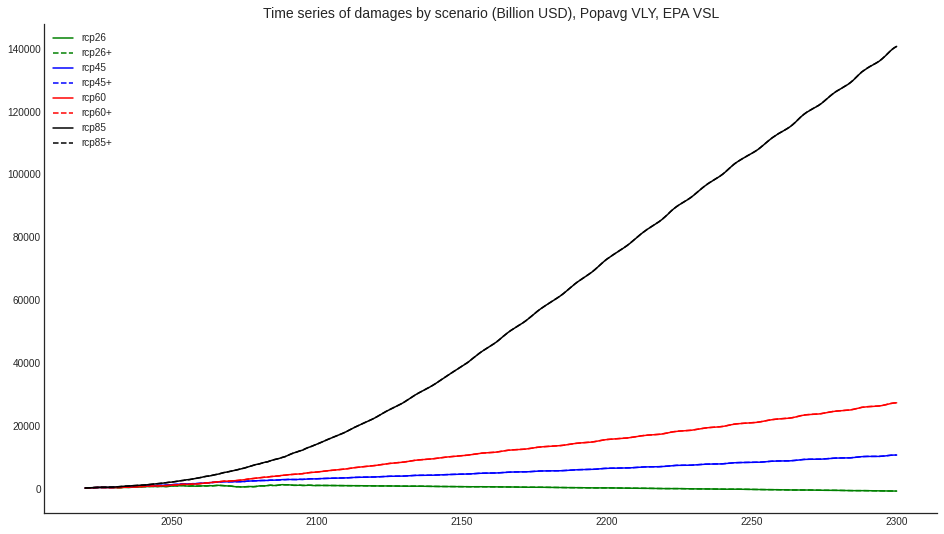

In [73]:
if generate_plots and scc_output == 'point-est':
    fig, ax = plt.subplots(1, 1)

    colors = ['green', 'blue', 'red', 'black']
    styles = ['solid', 'dashed']

    lines = []
    labels = []
    for r, rcp in enumerate(damages.rcp.values):
        for p, pulse in enumerate(damages.pulse.values):
            labels.append('{}{}'.format(rcp, ['', '+'][p]))
            lines.append(
                ax.plot(
                    damages.year,
                    damages.sel(rcp=rcp, pulse=pulse, vsl_value='epa', age_adjustment='vly', heterogeneity='popavg', variable=ssp).T,
                    color=colors[r],
                    linestyle=styles[p])[0])

    plt.legend(lines, labels)
    ax.axes.set_title(
        'Time series of damages by scenario (Billion USD), Popavg VLY, EPA VSL',
        size=14)

    sns.despine()

    fig.savefig('{}/figures/damage_projections_median_IGIA_{}_{}_{}_2100-fixed-{}.pdf'
                .format(OUTPUT_path, specification, ssp, version, hold_2100_damages_fixed))
    

### Plot time series of mortality damages by RCP and VSL measure (Billion USD)
Note that this is in Billion USD_2019, and is the damages from the 1GtC pulse. Previously, damages had been converted to a \$/tCO2 basis (or Billion \$/GtCO2). 

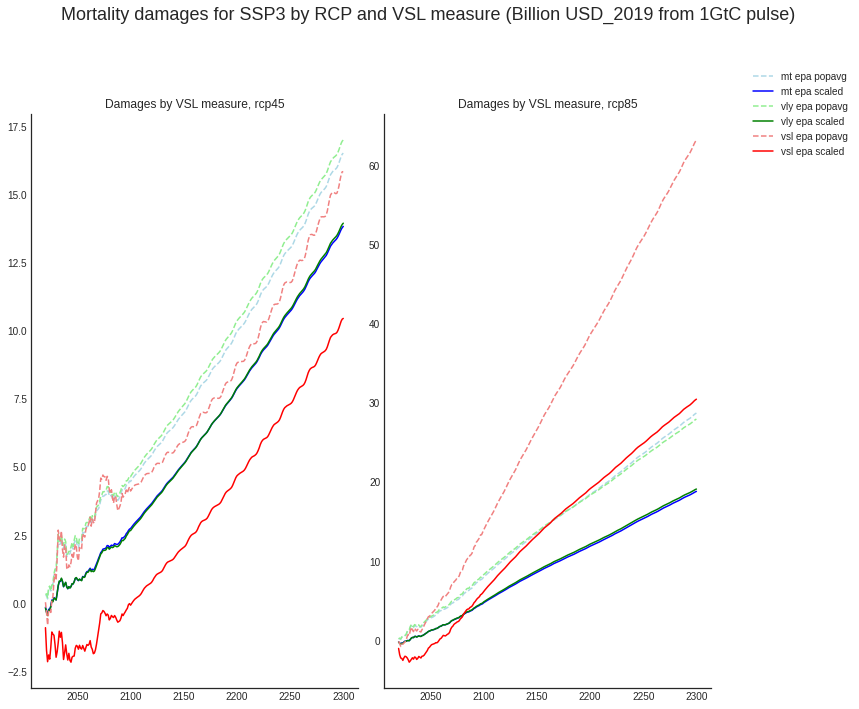

In [75]:
if generate_plots and scc_output == 'point-est':

    plotted = (
        (damages.sel(variable=ssp, rcp=['rcp45', 'rcp85']))
        .diff(dim='pulse').sel(pulse='pulse'))

    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    for r, rcp in enumerate(plotted.rcp):
        labels = []
        lines = []
        ii = 0
        for a, adj in enumerate(plotted.age_adjustment.values):
            for v, vsl in enumerate(plotted.vsl_value.values):
                for h, heterogeneity in enumerate(plotted.heterogeneity.values):
                    labels.append((adj, vsl, heterogeneity))
                    lines.append(
                        axes[r%2].plot(
                            plotted.year.values,
                            (
                                plotted
                                .sel(
                                    rcp=rcp,
                                    age_adjustment=adj,
                                    vsl_value=vsl,
                                    heterogeneity=heterogeneity)),
                            color=['lightblue', 'blue', 'lightgreen', 'green','lightcoral','red'][ii],
                            linestyle=('dashed' if h == 0 else 'solid'),
                            label='{}, {}, {}'.format(adj, vsl, heterogeneity))[0])
                    ii += 1

        axes[r%2].set_title('Damages by VSL measure, {}'.format(rcp.data))
        axes[r%2].set_facecolor('white')

    axes[1].legend(
        lines,
        ['{} {} {}'.format(*tuple(s)) for s in labels],
        bbox_to_anchor=(1.1, 1),
        loc='center left')

    fig.suptitle('Mortality damages for SSP3 by RCP and VSL measure (Billion USD_2019 from 1GtC pulse)', size=18)
    fig.set_facecolor('white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    sns.despine()
    plt.savefig('{}/figures/damage_projections_pulse_median_IGIA_byValuation_{}_{}_{}_2100-fixed-{}.pdf'
                .format(OUTPUT_path, specification, ssp, version, hold_2100_damages_fixed))
    

### Compue the SCC (NPV of damages)

discount the time series of damages using the formula

$$SCC=\sum_{y\in\left[2020, 2300\right]}{\frac{d_y}{\left({1+r}\right)^{y-2020}}}$$

Compute the time series of discounted damages. Then plot time series of mortality damages by RCP and VSL measure (Billion USD), discounted to present value and per ton CO2. 

Note that the plots are in Billion USD_2019, discounted to 2020, for RCP 8.5, with EPA VSL, value of life years, and globally varying income ('scaled') under SSP3. We want plots evaluated for discount rates 2.5%, 3%, and 5%.

In [81]:
discrates = [1., 1.5, 2., 2.5, 3., 5., 7.]

discdata = []
for r in discrates:
    discdata.append(damages / (1+r/100)**(damages.year - 2020))

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))


In [77]:
# Useful for diagnostics.

plotted_npv = (
    (current_equivalent_damages.sel(
        variable=ssp, rcp=['rcp45'], age_adjustment='vsl', vsl_value='epa', heterogeneity='scaled', discrate=3.0))
    .diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
plotted_npv = plotted_npv.to_dataframe("dr3")

plotted_damages = (
    (damages.sel(
        variable=ssp, rcp=['rcp45'], age_adjustment='vsl', vsl_value='epa', heterogeneity='scaled'))
    .diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
plotted_damages = plotted_damages.to_dataframe("dr0")

plotted_df = plotted_npv.merge(plotted_damages, on=['year','rcp'])[['dr3','dr0']]

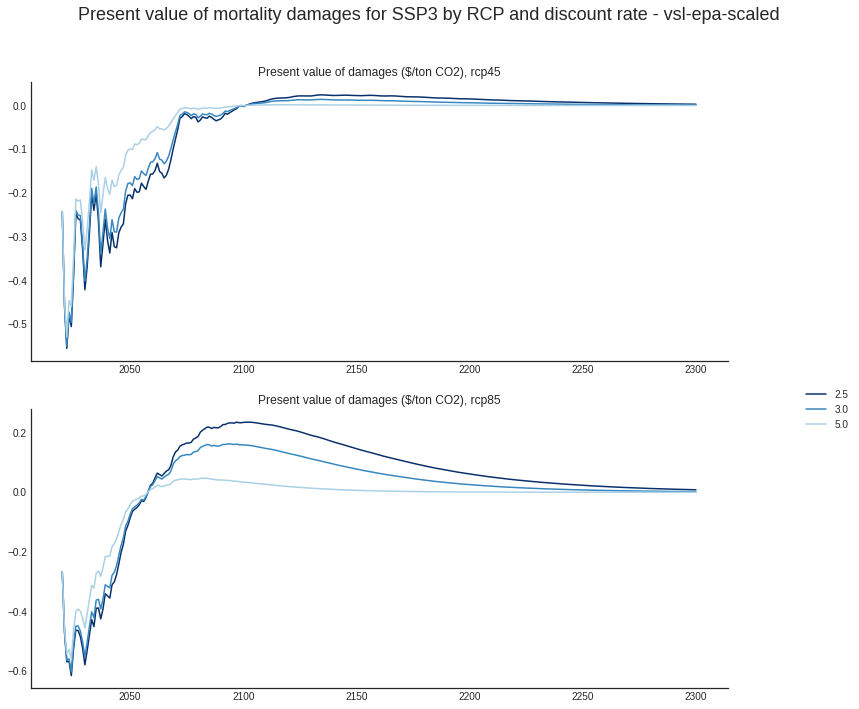

In [78]:
if generate_plots and scc_output == 'point-est':
    discrates_to_plot = [2.5, 3., 5.]
    
    a='vsl'
    v='epa'
    h='scaled'
    
    plotted = (
        (current_equivalent_damages.sel(
            variable=ssp, rcp=['rcp45', 'rcp85'], age_adjustment=a, vsl_value=v, heterogeneity=h))
        .diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    for r, rcp in enumerate(plotted.rcp):
        labels = []
        lines = []
        for dr in discrates_to_plot:
            labels.append((dr))

            lines.append(
                axes[r%2].plot(
                    plotted.year.values,
                    (
                        plotted
                        .sel(
                            rcp=rcp,
                            discrate=dr)),
                    #color=['lightblue', 'blue', 'lightgreen', 'green'][discrates_to_plot.index(dr)],
                    color=matplotlib.cm.Blues_r(float(discrates_to_plot.index(dr))/len(discrates_to_plot)),
                    linestyle=('solid'),
                    label='{}'.format(dr))[0])

        axes[r%2].set_title('Present value of damages ($/ton CO2), {}'.format(rcp.data))
        axes[r%2].set_facecolor('white')

    axes[1].legend(
        lines,
        ['{}'.format(s) for s in labels],
        bbox_to_anchor=(1.1, 1),
        loc='center left')

    fig.suptitle('Present value of mortality damages for {} by RCP and discount rate - {}-{}-{}'.format(ssp, a, v, h), size=18)
    fig.set_facecolor('white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    sns.despine()
    plt.savefig('{}/figures/damage_pv_projections_byDiscRate_IGIA_{}-{}-{}_{}_{}_{}_2100-fixed-{}.pdf'
                .format(OUTPUT_path, a, v, h, specification, ssp, version, hold_2100_damages_fixed))
    

### Compute the SCC (sum of discounted marginal damage time series) by discount rate and RCP

In [82]:
scc = (
    (current_equivalent_damages.diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_pre_2100 = (
    (current_equivalent_damages.sel(year=slice(2020, 2099)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_post_2100 = (
    (current_equivalent_damages.sel(year=slice(2100, 3000)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))


scc = xr.concat([scc, scc_pre_2100, scc_post_2100], pd.Index(['all', 'pre2100', 'post2100'], name='time_cut'))


In [83]:
scc

<xarray.DataArray (time_cut: 3, discrate: 7, variable: 1, rcp: 4, discount_type: 1, model: 1)>
array([[[[[[6.04431680e+00]],

          [[5.87074256e+01]],

          [[8.85471631e+01]],

          [[1.34042194e+02]]]],



        [[[[5.22351170e+00]],

          [[2.95627164e+01]],

          [[4.29393022e+01]],

          [[6.55575385e+01]]]],



...



        [[[[3.73384289e-02]],

          [[2.99745500e-01]],

          [[4.47149333e-01]],

          [[7.41791724e-01]]]],



        [[[[6.48085654e-03]],

          [[4.47188214e-02]],

          [[6.56212097e-02]],

          [[1.09945004e-01]]]]]])
Coordinates:
  * variable       (variable) object 'SSP0'
  * discount_type  (discount_type) object 'constant_model_collapsed'
  * model          (model) object "['IIASA GDP', 'OECD Env-Growth']"
    pulse          <U5 'pulse'
  * rcp            (rcp) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * discrate       (discrate) float64 1.0 1.5 2.0 2.5 3.0 5.0 7.0
  * time_cut       (time_cut) object 'all' 'pre2100' 'post2100'

In [88]:
scc.sel(time_cut='all').sel(rcp='rcp45').sel(discrate=1.5)

<xarray.DataArray (variable: 1, discount_type: 1, model: 1)>
array([[[29.56271637]]])
Coordinates:
  * variable       (variable) object 'SSP0'
  * discount_type  (discount_type) object 'constant_model_collapsed'
  * model          (model) object "['IIASA GDP', 'OECD Env-Growth']"
    pulse          <U5 'pulse'
    rcp            <U5 'rcp45'
    discrate       float64 1.5
    time_cut       <U3 'all'

### Export point estimate SCC to CSV

In [27]:
if scc_output == 'point-est':

    (   scc
        .to_series()
        .unstack('rcp')
        .to_csv('{}/scc_{}_{}_pulse{}GtC_{}_median_IGIA_2100-fixed-{}_MC.csv'.format(OUTPUT_path, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed))  ) 

    print(datetime.now() - startTime)

## Damage function uncertainty 

### Plot histogram of quantiles of the SCC, upweighting each quantile by its associated mass in the economic uncertainty distribution.

New quantiles are [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95], probability weights are each 0.05 except for the 5th and 95th quantiles, which are weighted 0.075 to account for the fact that they cover more of the range than all other quantiles (0 to .075 and .925 to 1, respectively). Note that these weights are calculated with the function get_weights, rather than being hard-coded as before.

In [28]:
def get_weights(quantiles):
    """
        Compute the weights of each quantile regression.
        `quantiles` must be between 0-1! 
    """
    quantiles = np.array(quantiles)
    # find midpoints between quantiles
    bounds = np.array([0] + ((quantiles[:-1] + quantiles[1:]) / 2).tolist() + [1])
    if (bounds > 1).any():
        raise RuntimeError('quantiles must be between 0-1')
    weights = np.diff(bounds)
    return weights

In [29]:
if scc_output == 'df-uncertainty':
    weights = get_weights(scc.pctile)

0 rcp45 mt epa popavg
1 rcp45 mt epa scaled
2 rcp45 vly epa popavg
3 rcp45 vly epa scaled
4 rcp45 vsl epa popavg
5 rcp45 vsl epa scaled
6 rcp85 mt epa popavg
7 rcp85 mt epa scaled
8 rcp85 vly epa popavg
9 rcp85 vly epa scaled
10 rcp85 vsl epa popavg
11 rcp85 vsl epa scaled


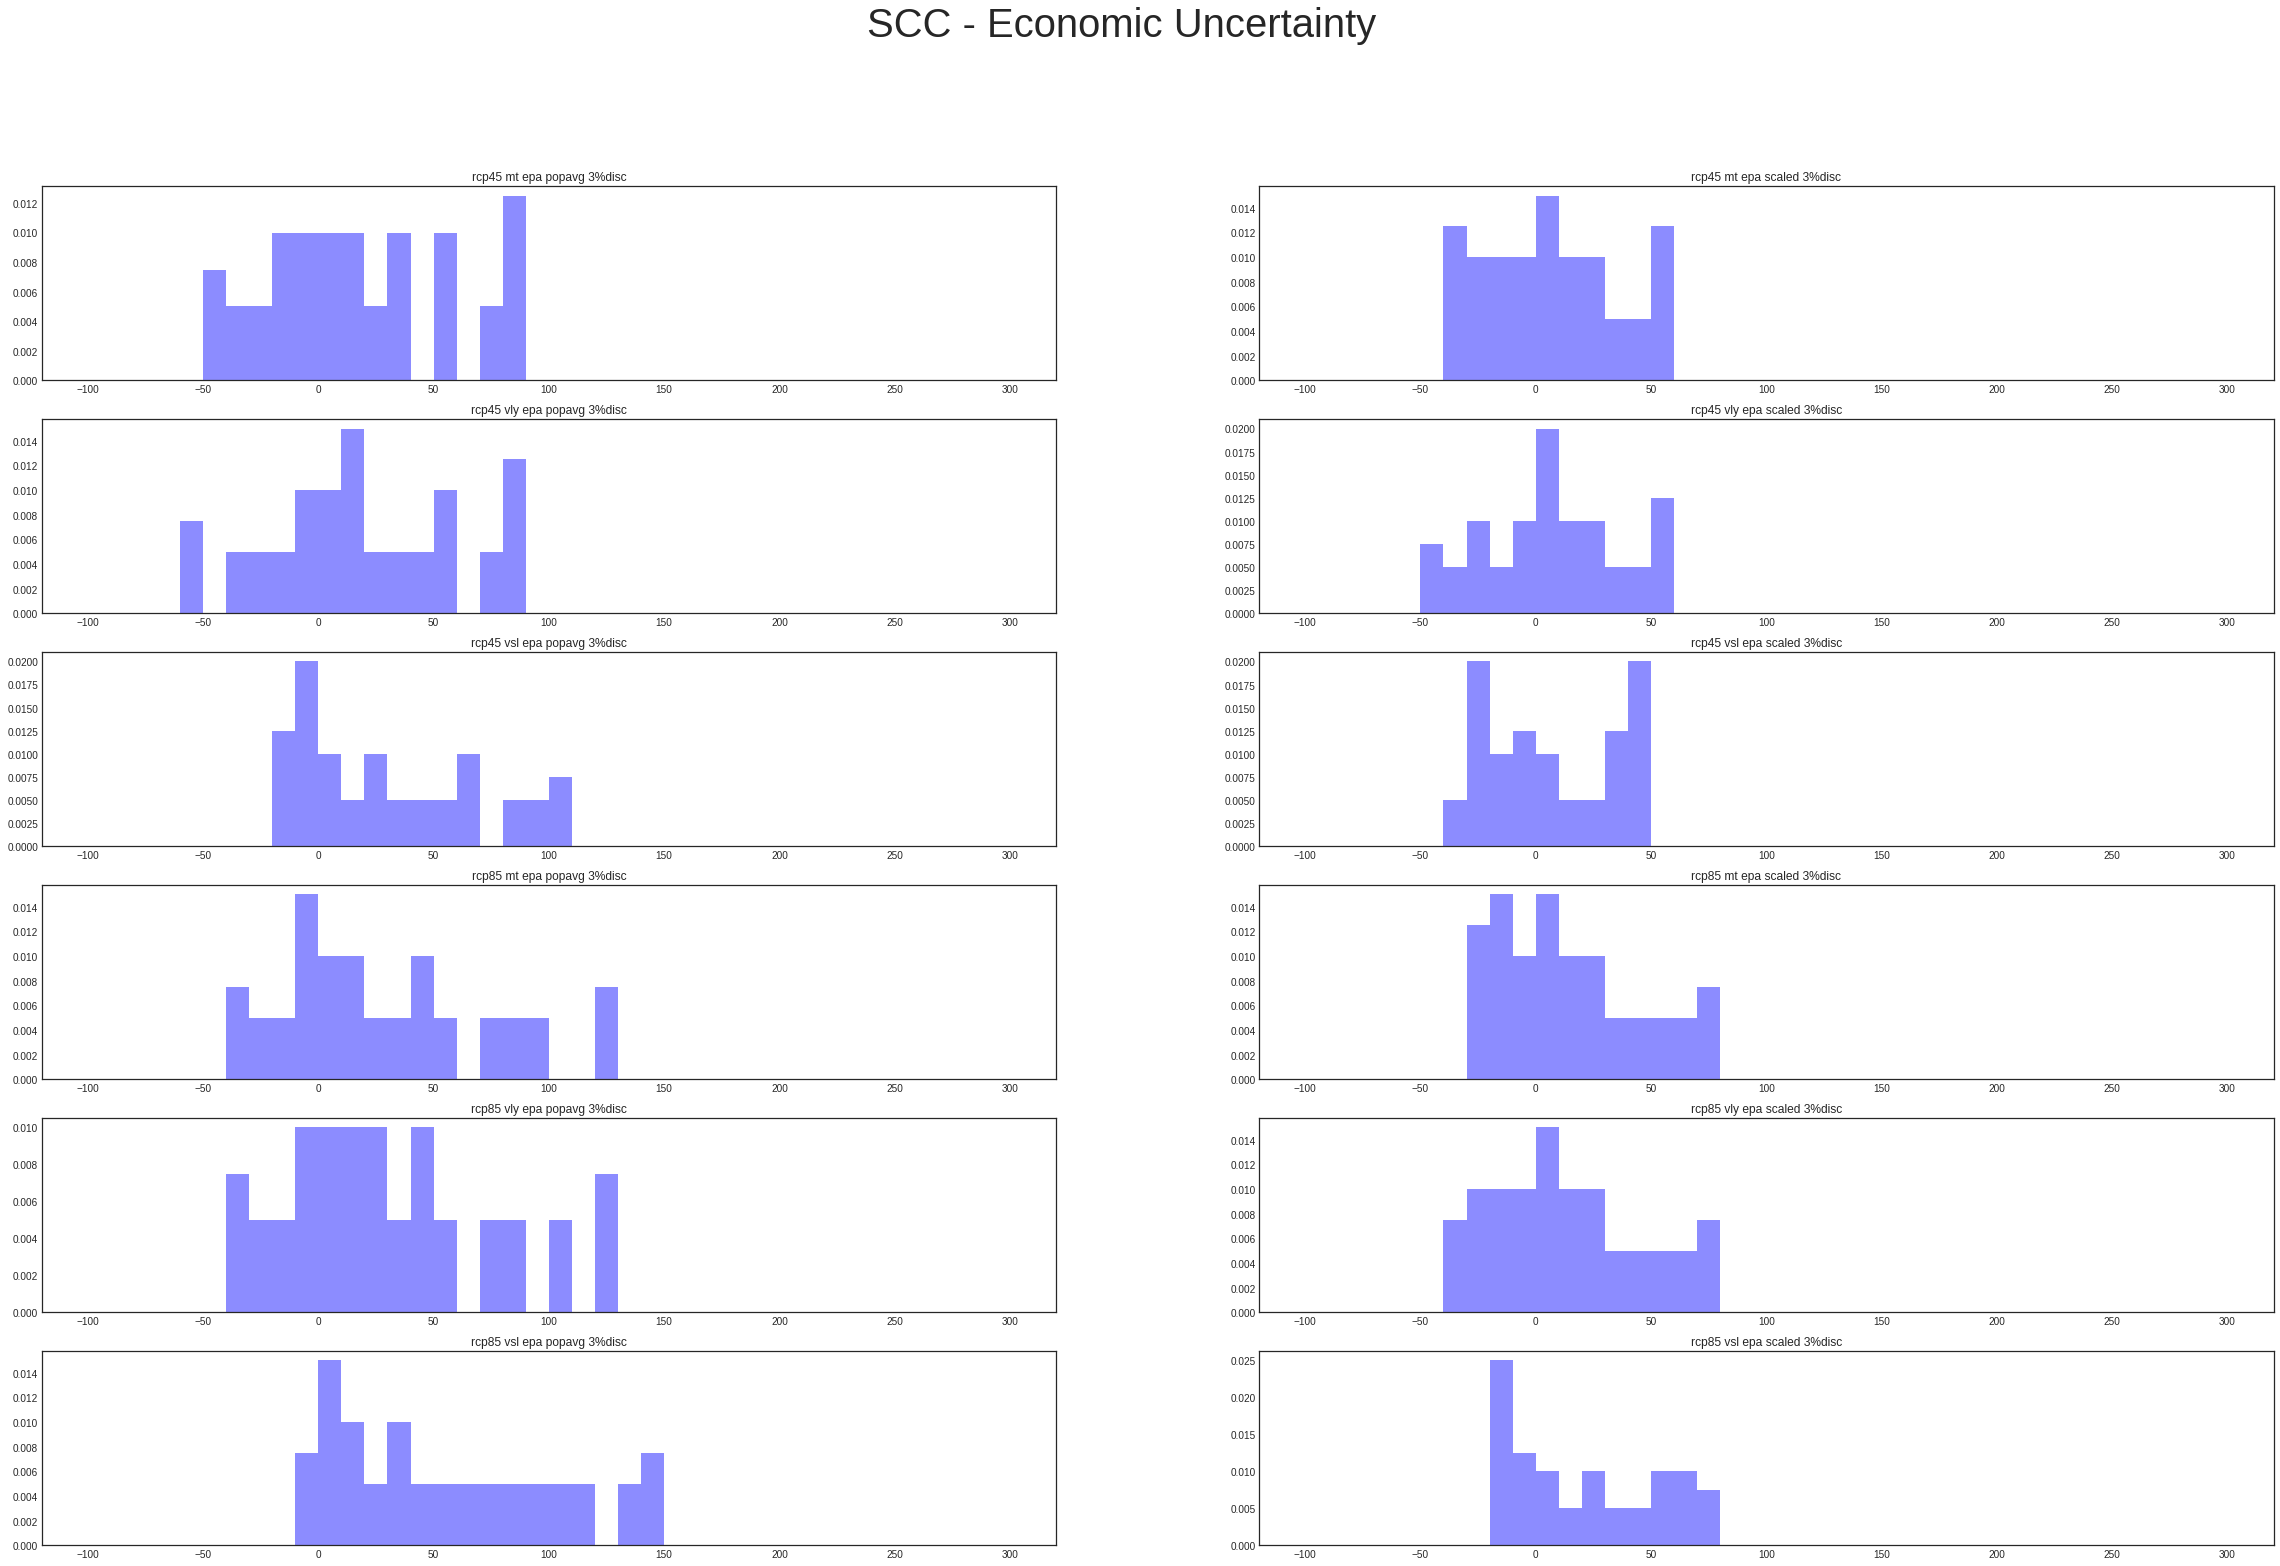

In [30]:
if scc_output == 'df-uncertainty':
    fig, axes = plt.subplots(6, 2, figsize=(40, 25))
    #fig, axes = plt.subplots(4, 3, figsize=(8, 5))

    # it = lambda x: tqdm.tqdm_notebook(list(enumerate(x.values)), leave=False)
    it = lambda x: list(enumerate(x.values))

    plotting = scc.sel(rcp=['rcp45', 'rcp85'], discrate=3.0)

    weights = np.array(weights)
    hist_bins = range(-100, 310, 10)
    ii = 0

    for ri, rcp in it(plotting.rcp):
        for ai, age in it(plotting.age_adjustment):
            for vi, vsl in it(plotting.vsl_value):
                for hi, het in it(plotting.heterogeneity):
                    #for di, disc in it(plotting.discrate):

                    print(ii, rcp, age, vsl, het)
                    slicers = dict(
                        #discrate=disc,
                        rcp=rcp,
                        age_adjustment=age,
                        vsl_value=vsl,
                        heterogeneity=het,
                        time_cut='all')

                    this = plotting.sel(**slicers)

                    ax = axes[ri*3+ai, vi*2+hi]
                    #print(this.values)
                    #print('di is: {}'.format(di))

                    #mask = (this.values > 0)
                    ax.hist(
                        this.values[0,:],
                        #np.log(this.values[mask]),
                        bins=hist_bins,
                        density=True,
                        color=['red', 'green', 'blue','orange','yellow','purple'][2],
                        alpha=0.45,
                        weights=weights)

                    #ax.set_xticklabels(['$10^{{{:0.0f}}}$'.format(i) for i in ax.get_xticks()])
                    ax.set_title('{} {} {} {} 3%disc'.format(rcp,age,vsl,het))
                    ii += 1

    fig.suptitle('SCC - Economic Uncertainty', size=40)
    #plt.savefig('{}/figures/scc_hist_{}_{}_2100-fixed-{}.pdf'.format(OUTPUT_path, specification, version, hold_2100_damages_fixed))

In [31]:
if scc_output == 'df-uncertainty':
    age = 'mt'
    rcp = 'rcp85'
    vsl = 'epa'

    slicers = dict(
            #discrate=disc,
            rcp=rcp,
            age_adjustment=age,
            vsl_value=vsl,
            heterogeneity=het,
            time_cut='all')

    this = plotting.sel(**slicers)
    this.name = 'test'
    this.to_dataframe()
    it(plotting.age_adjustment)

These plots look maybe log-normal or maybe normal? Hard to say. So, fit both a normal and a log-normal distribution in each valuation case, then report the interquartile range (IQR) for each. To be safe, also report the SCC values of the 25th and 75th quantiles of the damage function (this would be the SCC IQR if the SCC were monotonic in damage function quartile, which is nearly but not exactly the case).

In [32]:
if scc_output == 'df-uncertainty':
    # Save the IQRs resulting from the 25,75 ptiles of the damage function
    dmg_IQRs = scc.sel(pctile=[0.25,0.75],time_cut='all')

    # Save IQRs from fitting a distribution of type fit_type
    my_IQRs = scc.sel(pctile=[0.25,0.75],time_cut='all')

    fit_type = 'norm' #'lognorm' or 'norm'

    for ri, rcp in it(scc.rcp):
        for ai, age in it(scc.age_adjustment):
            for vi, vsl in it(scc.vsl_value):
                for hi, het in it(scc.heterogeneity):
                    for di, disc in it(scc.discrate):

                        slicers = dict(
                            discrate=disc,
                            rcp=rcp,
                            age_adjustment=age,
                            vsl_value=vsl,
                            heterogeneity=het,
                            time_cut='all')

                        this = scc.sel(**slicers)

                        if fit_type == 'lognorm':
                            # Fit a lognormal distribution
                            # Helpful: https://stackoverflow.com/questions/51410155/proper-way-to-fit-a-lognormal-distribution-with-weight-in-python
                            logs = np.log(this.values[0,:])
                            muhat = np.average(logs, weights=weights)
                            # varhat is the weighted variance of ln(x).  There isn't a function in
                            # numpy for the weighted variance, so we compute it using np.average.
                            varhat = np.average((logs - muhat)**2, weights=weights)

                            shape = np.sqrt(varhat)
                            scale = np.exp(muhat)
                            #print('{} {}'.format(shape, scale))

                            if ~np.isnan(shape):
                                randoms = lognorm.rvs(s=shape, scale=scale, size=1000)
                                pt = np.percentile(randoms,[25, 75])
                            else:
                                pt = np.array([np.nan, np.nan])
                        else:
                            # Fit a normal distribution
                            muhat = np.average(this.values[0,:], weights=weights)
                            varhat = np.average((this.values[0,:] - muhat)**2, weights=weights)
                            scale = np.sqrt(varhat)
                            randoms = norm.rvs(loc=muhat, scale=scale, size=1000)
                            pt = np.percentile(randoms,[25, 75])


                        iqr_slicers = dict(
                            discrate=disc,
                            rcp=rcp,
                            age_adjustment=age,
                            vsl_value=vsl,
                            heterogeneity=het)

                        my_IQRs.loc[iqr_slicers] = pt

                        # Add the SCCs associated with the 25 and 75 quantile damage functions
                        tmp = scc.sel(**slicers)
                        dmg_IQRs.loc[iqr_slicers] = tmp.sel(pctile=[0.25,0.75])   

In [36]:
print('{}/scc_IQRs_{}_{}_{}_pulse{}GtC_{}_2100-fixed-{}_v2.csv'.format(OUTPUT_path, fit_type, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed))

/mnt/Global_ACP/MORTALITY/release_2020/data/5_scc/global_scc/quadratic/wo_costs/scc_IQRs_norm_mortality_quadratic_IGIA_df-uncertainty_SSP3_pulse1.0GtC_v0.5_2100-fixed-False_v2.csv


In [37]:
if scc_output == 'df-uncertainty':
    (
        my_IQRs
        .to_series()
        .unstack('rcp')
        .to_csv('{}/scc_IQRs_{}_{}_{}_pulse{}GtC_{}_2100-fixed-{}_v2.csv'.format(OUTPUT_path, fit_type, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed)))

    (
        dmg_IQRs
        .to_series()
        .unstack('rcp')
        .to_csv('{}/scc_IQRs_dmg-mapping_{}_{}_pulse{}GtC_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed)))


## Plot graveyard

In [ ]:
if 1 == 0:
    # Plot time series of damages incurred due to pulse
    # We aren't currently using this plot. If we want it some indexing needs to be updated.
    if generate_plots and scc_output == 'point-est':
        fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

        if numvars == 1:
            axes = np.array([[axes]])

        for vi, var in enumerate(damages['variable'].values):
            (damages.sel(variable=var) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
            axes[vi//2, vi%2].axes.set_title(
                'Time series of damages incurred due to pulse (USD / ton CO2)\n{}'.format(var),
                size=11)

        sns.despine()
        plt.tight_layout()
        plt.savefig('../outputs/images/damage_projections_pulse_median_IGIA_{}_{}_{}_{}_2100-fixed-{}.pdf'
                    .format(specification, ssp, version, scenario_to_run, hold_2100_damages_fixed))

In [ ]:
if 1 == 0:
    # We aren't currently using this plot. If we want it some indexing needs to be updated.

    if generate_plots and scc_output == 'point-est':
        fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

        if numvars == 1:
            axes = np.array([[axes]])

        for vi, var in enumerate(damages['variable'].values):
            scc.sel(variable=var).sel(time_cut='all').plot.line(x='discrate', ax=axes[vi//2, vi%2])
            axes[vi//2, vi%2].set_title(var)

        plt.savefig('../outputs/images/scc_{}_{}_{}_2100-fixed-{}.pdf'.format(specification, version, scenario_to_run, hold_2100_damages_fixed))
        plt.tight_layout()
        sns.despine()